In [5]:
import os
import glob
import pandas as pd
import numpy as np

METADATA_PATH = "metadata_clean.csv"
TEXT_DIR = "clean"

def load_corpus():
    df = pd.read_csv(METADATA_PATH, dtype=str)
    if "date_standard" in df.columns:
        df["date_standard"] = pd.to_datetime(df["date_standard"])
        df = df[df["date_standard"] < "1928-01-01"]
    else:
        raise ValueError("metadata_clean.csv 中缺少 date_standard 列")

    if "Gale Document Number" not in df.columns:
        raise ValueError("metadata_clean.csv 中缺少 'Gale Document Number' 列")

    df["gale_id"] = df["Gale Document Number"].astype(str).str.split("|").str[-1]

    txt_paths = glob.glob(os.path.join(TEXT_DIR, "*.txt"))
    gale_ids = set(df["gale_id"])

    id2path = {}
    for path in txt_paths:
        name = os.path.splitext(os.path.basename(path))[0]
        for gid in gale_ids:
            if name.endswith(gid):
                id2path[gid] = path
                break

    def read_text(gid):
        path = id2path.get(gid)
        if path and os.path.exists(path):
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                return f.read()
        return None

    df["text"] = df["gale_id"].apply(read_text)
    df = df.dropna(subset=["text"])

    # 方便后面用的几列
    if "Publication Title" in df.columns:
        df["publication"] = df["Publication Title"]
    else:
        df["publication"] = "Unknown"

    print("有效文档数：", len(df))
    return df

corpus_df = load_corpus()


有效文档数： 1150


In [7]:
#pip install wordcloud

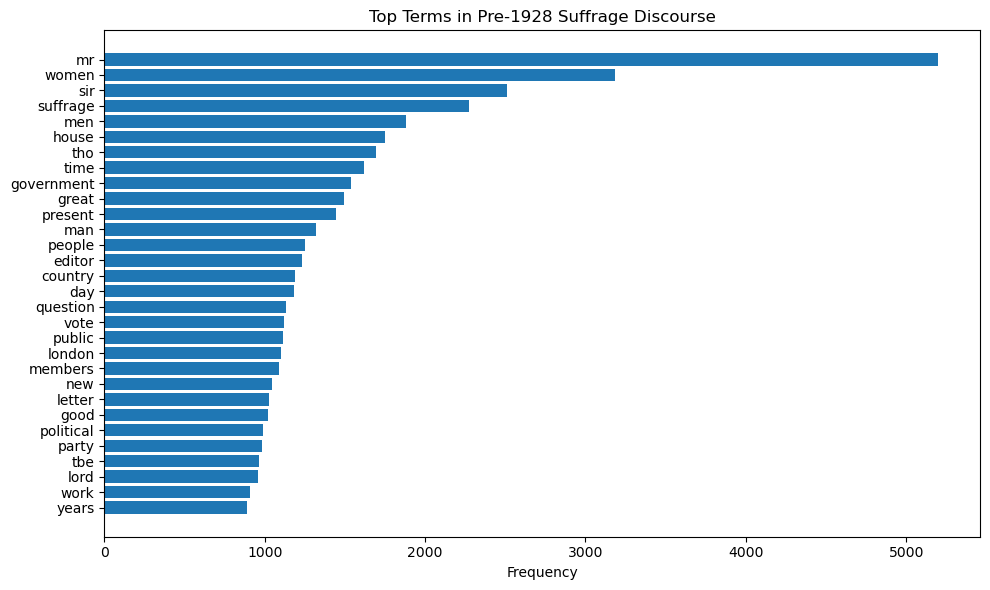

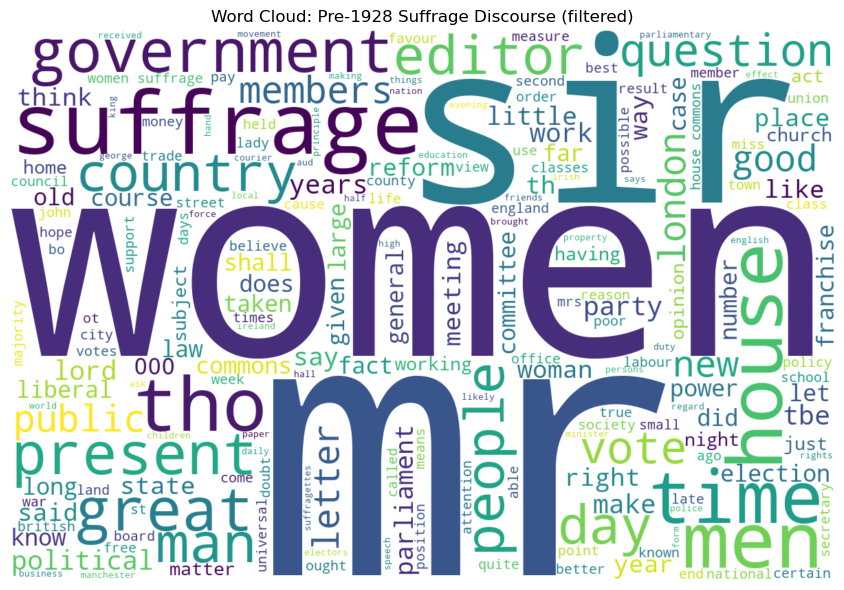

In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

def get_vectorizer(min_df=5, max_df=0.8, ngram_range=(1,2)):
    return CountVectorizer(
        lowercase=True,
        stop_words="english",
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range
    )

def plot_top_terms(df, top_n=30):
    vectorizer = get_vectorizer()
    X = vectorizer.fit_transform(df["text"])
    freqs = X.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    term_freq = pd.DataFrame({"term": terms, "freq": freqs}).sort_values("freq", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(term_freq["term"][::-1], term_freq["freq"][::-1])
    plt.xlabel("Frequency")
    plt.title("Top Terms in Pre-1928 Suffrage Discourse")
    plt.tight_layout()
    plt.show()

    return term_freq, vectorizer, X

top_terms, vectorizer, X = plot_top_terms(corpus_df)

def plot_wordcloud(df):
    # 用和柱状图一致的参数（按你实际用的改）
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words="english",
        min_df=5,          # 文档数太少的词丢掉
        max_df=0.8,        # 出现在过多文档中的泛词丢掉
        ngram_range=(1,2)  # 一元词 + 二元短语
    )

    X = vectorizer.fit_transform(df["text"])
    terms = vectorizer.get_feature_names_out()
    freqs = np.asarray(X.sum(axis=0)).ravel()

    # 构造成 {term: freq}，只根据过滤后的特征空间生成词云
    freq_dict = {
        term: int(freq)
        for term, freq in zip(terms, freqs)
        if freq > 0
    }

    wc = WordCloud(
        width=1200,
        height=800,
        background_color="white",
        max_words=200
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud: Pre-1928 Suffrage Discourse (filtered)")
    plt.tight_layout()
    plt.show()

plot_wordcloud(corpus_df)


In [33]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

TEXT_COL = "text"

df = corpus_df.copy()
df["date_standard"] = pd.to_datetime(df["date_standard"], errors="coerce")
df = df.dropna(subset=[TEXT_COL, "date_standard"])
df = df[df["date_standard"] < "1928-01-01"].copy()

df["year"] = df["date_standard"].dt.year

def to_5yr_bin(y):
    return int((y // 5) * 5)

df["year_5bin"] = df["year"].apply(to_5yr_bin)


In [35]:
# 1. 全语料向量化
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=5,         # 至少在5篇文档中出现
    max_df=0.8,       # 出现在80%以上文档中的词丢掉
    ngram_range=(1,1) # 先用unigram，有需要再加bigrams
)

X = vectorizer.fit_transform(df[TEXT_COL])
terms = vectorizer.get_feature_names_out()

# 2. 按5年区间聚合 term frequency（这里用相对频率，便于比较）
df_bins = df[["year_5bin"]].copy()
df_bins["row_id"] = np.arange(len(df))

bin_labels = sorted(df["year_5bin"].unique())
bin_term_freq = {}

for b in bin_labels:
    idx = df_bins.index[df_bins["year_5bin"] == b].tolist()
    if not idx:
        continue
    subX = X[idx]
    counts = np.asarray(subX.sum(axis=0)).ravel()
    total = counts.sum()
    if total == 0:
        freqs = np.zeros_like(counts, dtype=float)
    else:
        freqs = counts / total
    bin_term_freq[b] = freqs

bin_term_freq_df = pd.DataFrame.from_dict(
    bin_term_freq,
    orient="index",
    columns=terms
).sort_index()


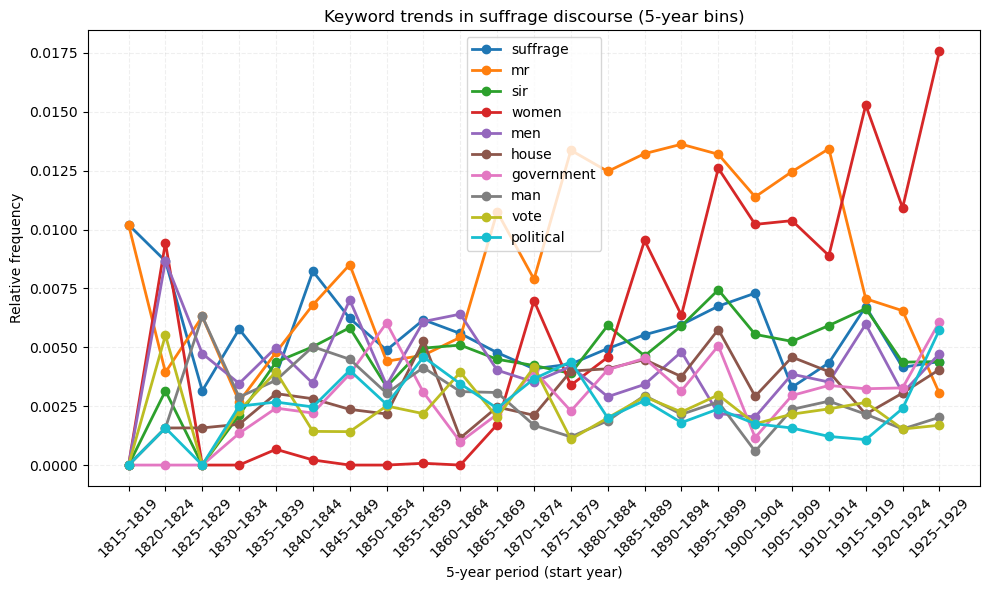

In [37]:
def plot_keyword_trends(bin_freq_df, keywords):
    available = [w for w in keywords if w in bin_freq_df.columns]
    if not available:
        print("这些关键词在向量空间里不存在，可能被过滤掉了。")
        return

    x = bin_freq_df.index.values
    plt.figure(figsize=(10, 6))

    for w in available:
        y = bin_freq_df[w].values
        plt.plot(x, y, marker="o", linewidth=2, label=w)

    plt.xlabel("5-year period (start year)")
    plt.ylabel("Relative frequency")
    plt.title("Keyword trends in suffrage discourse (5-year bins)")
    plt.xticks(
        x,
        [f"{int(v)}–{int(v+4)}" for v in x],
        rotation=45
    )
    plt.grid(alpha=0.2, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 你可以根据自己的研究重点调整这几个词
keywords = [
    "suffrage",
    "mr",
    "sir",
    "women",
    "men",
    "house",
    "government",
    "man",
    "vote",
    "political"
]

plot_keyword_trends(bin_term_freq_df, keywords)


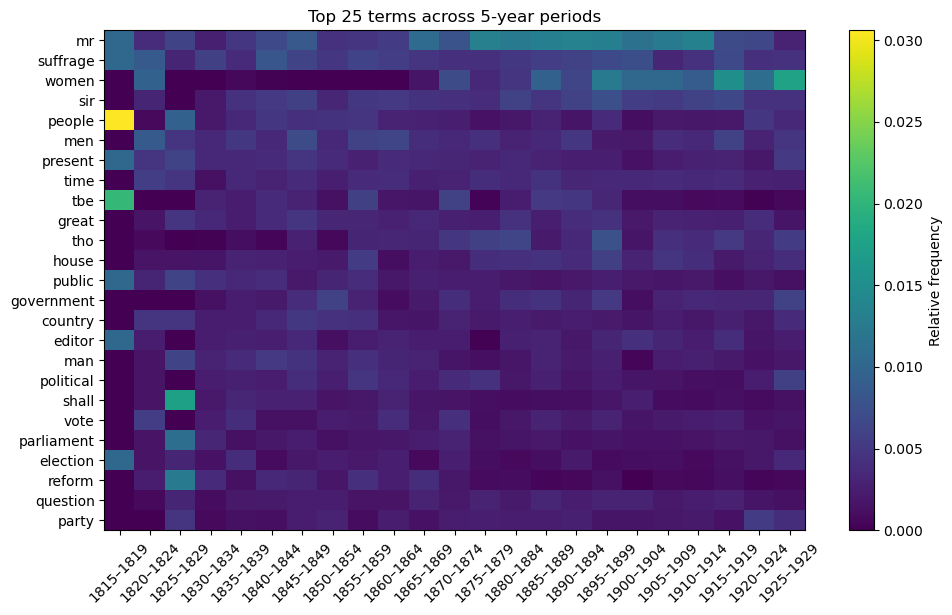

In [39]:
def plot_top_terms_heatmap(bin_freq_df, top_n=30):
    # 全时期总频率最高的 top_n 词
    global_freq = bin_freq_df.sum(axis=0)
    top_terms = global_freq.sort_values(ascending=False).head(top_n).index

    sub = bin_freq_df[top_terms]

    plt.figure(figsize=(10, max(6, top_n * 0.25)))
    plt.imshow(sub.T, aspect="auto")
    plt.colorbar(label="Relative frequency")
    plt.yticks(range(len(top_terms)), top_terms)
    plt.xticks(
        range(len(sub.index)),
        [f"{int(v)}–{int(v+4)}" for v in sub.index],
        rotation=45
    )
    plt.title(f"Top {top_n} terms across 5-year periods")
    plt.tight_layout()
    plt.show()

plot_top_terms_heatmap(bin_term_freq_df, top_n=25)


In [1]:
#import sys
#!{sys.executable} -m pip install -U pip
#!{sys.executable} -m pip install sentence-transformers --timeout 600 -v

In [ ]:
#pip install hf_xet

In [ ]:
import matplotlib.pyplot as plt

def plot_topics_by_decade(df, min_total=20):
    counts = (
        df.groupby(["decade", "topic_label"])
          .size()
          .reset_index(name="count")
    )

    pivot = counts.pivot(index="decade", columns="topic_label", values="count").fillna(0)

    # 去掉总量太小的 topic，避免图太乱
    valid_topics = [c for c in pivot.columns if pivot[c].sum() >= min_total]
    pivot = pivot[valid_topics]

    # decade 排序
    pivot = pivot.sort_index()

    # 堆叠面积图
    plt.figure(figsize=(12, 7))
    x = pivot.index.values
    ys = [pivot[col].values for col in pivot.columns]
    plt.stackplot(x, *ys, labels=pivot.columns)
    plt.xlabel("Decade")
    plt.ylabel("Number of articles")
    plt.title("Unsupervised LLM-based topics over decades")
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.show()

    # 热力图
    plt.figure(figsize=(10, 6))
    plt.imshow(pivot.T, aspect="auto")
    plt.colorbar(label="Number of articles")
    plt.yticks(range(len(pivot.columns)), pivot.columns)
    plt.xticks(range(len(pivot.index)), pivot.index, rotation=45)
    plt.title("Topic counts by decade (LLM-discovered)")
    plt.tight_layout()
    plt.show()

plot_topics_by_decade(df)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Voiresa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Voiresa\AppData\Local\Temp\ipykernel_43660\530674151.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


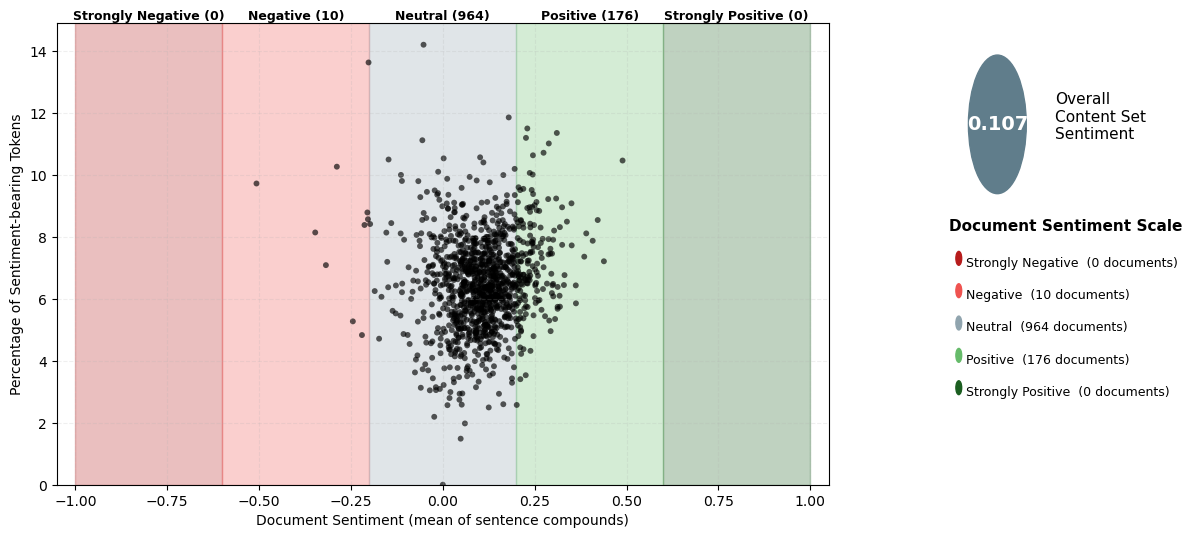

In [19]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import nltk
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt')

TEXT_COL = "text"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 更保守的情感区间
SENTIMENT_BANDS = [
    (-1.0, -0.6, "Strongly Negative", "#b71c1c"),
    (-0.6, -0.2, "Negative",          "#ef5350"),
    (-0.2,  0.2, "Neutral",           "#90a4ae"),
    ( 0.2,  0.6, "Positive",          "#66bb6a"),
    ( 0.6,  1.0, "Strongly Positive", "#1b5e20"),
]

analyzer = SentimentIntensityAnalyzer()

def doc_sentiment_avg_sentence(text: str) -> float:
    """对每篇文章：按句子计算 compound，再取平均，更稳健。"""
    if not isinstance(text, str) or not text.strip():
        return 0.0
    sents = sent_tokenize(text)
    if not sents:
        return 0.0
    scores = [analyzer.polarity_scores(s)["compound"] for s in sents]
    return float(np.mean(scores))

def sentiment_token_ratio(text: str) -> float:
    """使用 VADER 词典估计情感词比例，作为 y 轴。"""
    if not isinstance(text, str):
        return 0.0
    tokens = re.findall(r"[A-Za-z']+", text.lower())
    if not tokens:
        return 0.0
    senti_words = [t for t in tokens if t in analyzer.lexicon]
    return len(senti_words) / len(tokens) * 100.0

def assign_band(score: float) -> str:
    for left, right, name, color in SENTIMENT_BANDS:
        if left <= score < right:
            return name
    if score >= 1.0:
        return SENTIMENT_BANDS[-1][2]
    if score < -1.0:
        return SENTIMENT_BANDS[0][2]
    return "Unclassified"

# ===== 计算情感指标 =====
df = corpus_df.copy().dropna(subset=[TEXT_COL])

df["sentiment"] = df[TEXT_COL].apply(doc_sentiment_avg_sentence)
df["sentiment_token_pct"] = df[TEXT_COL].apply(sentiment_token_ratio)

# 加一点抖动让点云更好看
jitter = (np.random.rand(len(df)) - 0.5) * 0.6
df["y_plot"] = np.clip(df["sentiment_token_pct"] + jitter, 0, None)

df["sentiment_band"] = df["sentiment"].apply(assign_band)

band_counts = (
    df["sentiment_band"]
    .value_counts()
    .reindex([b[2] for b in SENTIMENT_BANDS], fill_value=0)
)

overall_mean = df["sentiment"].mean()

# ===== 画图 =====
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.25)

ax = fig.add_subplot(gs[0])

# 背景色带
for left, right, name, color in SENTIMENT_BANDS:
    ax.axvspan(left, right, color=color, alpha=0.28)

# 散点
ax.scatter(
    df["sentiment"],
    df["y_plot"],
    s=18,
    c="black",
    alpha=0.65,
    edgecolors="none"
)

ax.set_xlim(-1.05, 1.05)
ax.set_ylim(0, max(df["y_plot"].max() * 1.05, 10))

ax.set_xlabel("Document Sentiment (mean of sentence compounds)")
ax.set_ylabel("Percentage of Sentiment-bearing Tokens")


ax.grid(alpha=0.2, linestyle="--")

# 顶部写区间 + 数量
for left, right, name, color in SENTIMENT_BANDS:
    mid = (left + right) / 2
    count = int(band_counts.get(name, 0))
    label = f"{name} ({count})"
    ax.text(
        mid, ax.get_ylim()[1],
        label,
        ha="center", va="bottom",
        fontsize=9,
        color="black",
        fontweight="bold"
    )

# 右侧信息面板
ax_info = fig.add_subplot(gs[1])
ax_info.axis("off")
ax_info.set_xlim(0, 1)
ax_info.set_ylim(0, 1)

# Overall sentiment 徽章
circle_x, circle_y, r = 0.25, 0.78, 0.15
circle = plt.Circle((circle_x, circle_y), r, color="#607d8b")
ax_info.add_patch(circle)
ax_info.text(
    circle_x, circle_y,
    f"{overall_mean:.3f}",
    ha="center", va="center",
    color="white",
    fontsize=14,
    fontweight="bold"
)
ax_info.text(
    0.55, circle_y + 0.07,
    "Overall\nContent Set\nSentiment",
    ha="left", va="top",
    fontsize=11
)

# 文档情感等级
ax_info.text(
    0.0, 0.55,
    "Document Sentiment Scale",
    fontsize=11,
    fontweight="bold"
)

y_pos = 0.48
for left, right, name, color in SENTIMENT_BANDS:
    count = int(band_counts.get(name, 0))
    ax_info.add_patch(plt.Circle((0.05, y_pos + 0.01), 0.015, color=color))
    ax_info.text(
        0.09, y_pos,
        f"{name}  ({count} documents)",
        ha="left", va="center",
        fontsize=9,
        color="black"
    )
    y_pos -= 0.07

plt.tight_layout()
plt.show()


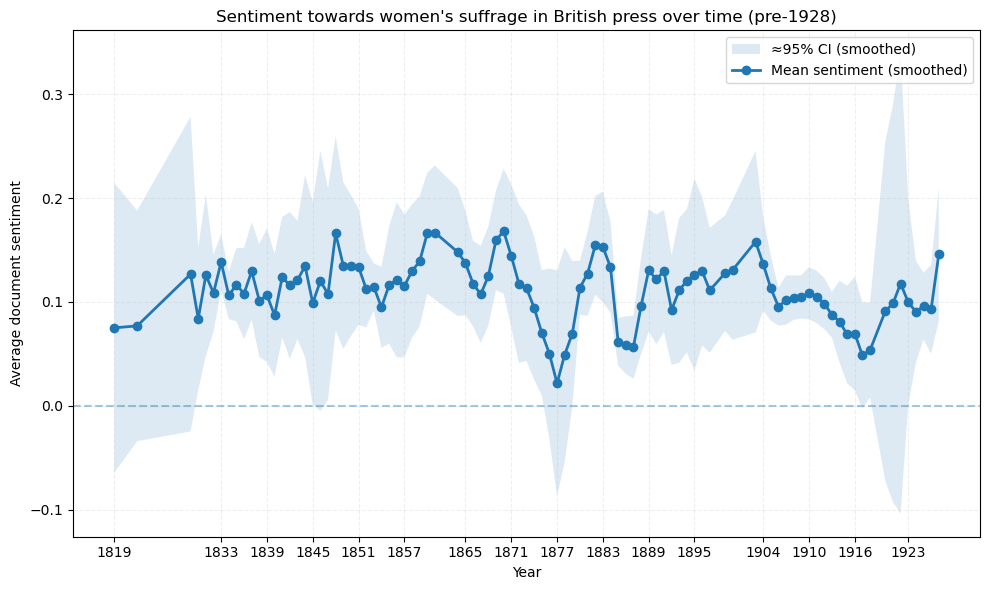

,mean_sent,count
year,,
1912,0.076,81
1913,0.098,115
1914,0.090,57
1915,0.056,9
1916,0.061,13
1917,0.092,12
1918,-0.007,5
1920,0.076,2
1921,0.205,2


In [23]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt', quiet=True)

TEXT_COL = "text"

analyzer = SentimentIntensityAnalyzer()

def doc_sentiment_avg_sentence(text: str) -> float:
    """按句子算 VADER compound，再取平均，更适合长篇新闻/历史文本。"""
    if not isinstance(text, str) or not text.strip():
        return 0.0
    sents = sent_tokenize(text)
    if not sents:
        return 0.0
    scores = [analyzer.polarity_scores(s)["compound"] for s in sents]
    return float(np.mean(scores))

# ===== 1. 准备数据 =====
df = corpus_df.copy()
df["date_standard"] = pd.to_datetime(df["date_standard"], errors="coerce")
df = df.dropna(subset=[TEXT_COL, "date_standard"])

# 只看 1928 年之前
df = df[df["date_standard"] < "1928-01-01"].copy()

# 如果还没计算 sentiment，就算一列
if "sentiment" not in df.columns:
    df["sentiment"] = df[TEXT_COL].apply(doc_sentiment_avg_sentence)

df = df.dropna(subset=["sentiment"])
df["year"] = df["date_standard"].dt.year

# 可选：如果年份跨度很大，可以限制在某个合理研究区间
# df = df[(df["year"] >= 1860) & (df["year"] <= 1927)]

# ===== 2. 按年份聚合 =====
yearly = (
    df.groupby("year")["sentiment"]
      .agg(["mean", "median", "count", "std"])
      .rename(columns={"mean": "mean_sent", "median": "median_sent"})
)

# 处理标准差为 NaN（只有一篇文档的年份）
yearly["std"] = yearly["std"].fillna(0.0)

# 计算标准误和一个简单双侧约 95% 置信区间
yearly["se"] = yearly["std"] / np.sqrt(yearly["count"].clip(lower=1))
yearly["ci_low"] = yearly["mean_sent"] - 1.96 * yearly["se"]
yearly["ci_high"] = yearly["mean_sent"] + 1.96 * yearly["se"]

# 可选平滑：用 3 年滚动均值，让曲线更稳一点
yearly["mean_smooth"] = yearly["mean_sent"].rolling(window=3, center=True, min_periods=1).mean()
yearly["ci_low_smooth"] = yearly["ci_low"].rolling(window=3, center=True, min_periods=1).mean()
yearly["ci_high_smooth"] = yearly["ci_high"].rolling(window=3, center=True, min_periods=1).mean()

# ===== 3. 画图 =====
fig, ax = plt.subplots(figsize=(10, 6))

x = yearly.index.values

# 置信区间阴影（使用平滑后的）
ax.fill_between(
    x,
    yearly["ci_low_smooth"],
    yearly["ci_high_smooth"],
    alpha=0.15,
    label="≈95% CI (smoothed)"
)

# 平滑后的年份均值情感曲线
ax.plot(
    x,
    yearly["mean_smooth"],
    marker="o",
    linewidth=2,
    label="Mean sentiment (smoothed)"
)

# 辅助线：0 为中性
ax.axhline(0, linestyle="--", alpha=0.4)

ax.set_xlabel("Year")
ax.set_ylabel("Average document sentiment")
ax.set_title("Sentiment towards women's suffrage in British press over time (pre-1928)")

# 只在年份较多时稀疏一下刻度，可按需要删掉这行
if len(x) > 20:
    step = max(1, len(x)//15)
    ax.set_xticks(x[::step])

ax.legend()
ax.grid(alpha=0.2, linestyle="--")

plt.tight_layout()
plt.show()

# 顺便看看每年文档数量，帮助解释波动
display(
    yearly[["mean_sent", "count"]]
    .tail(15)
    .style.format({"mean_sent": "{:.3f}"})
)


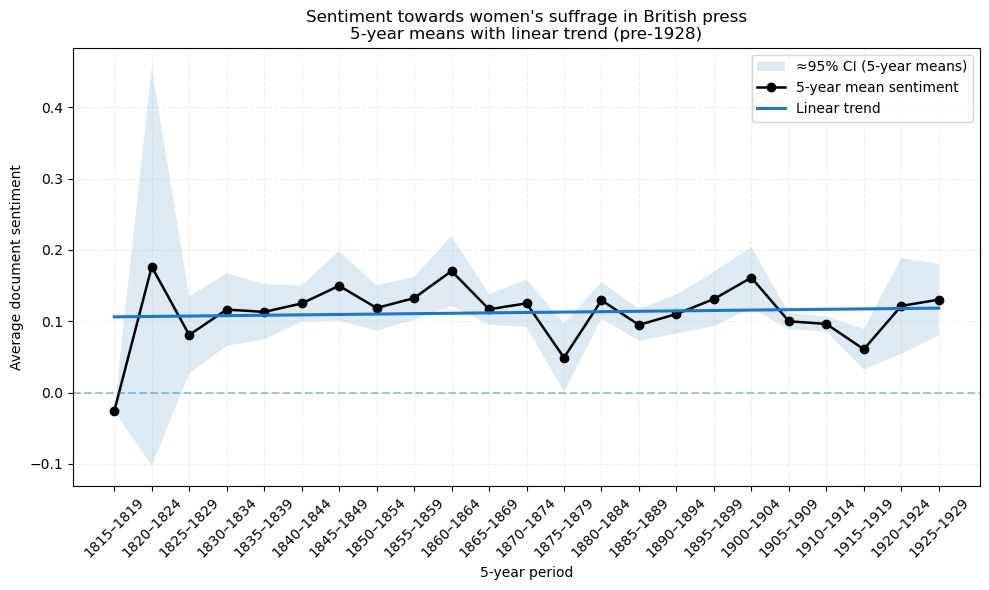

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('punkt', quiet=True)

TEXT_COL = "text"
analyzer = SentimentIntensityAnalyzer()

def doc_sentiment_avg_sentence(text: str) -> float:
    """按句子计算 VADER compound 后取平均。"""
    if not isinstance(text, str) or not text.strip():
        return 0.0
    sents = sent_tokenize(text)
    if not sents:
        return 0.0
    scores = [analyzer.polarity_scores(s)["compound"] for s in sents]
    return float(np.mean(scores))

# ===== 1. 准备数据 =====
df = corpus_df.copy()
df["date_standard"] = pd.to_datetime(df["date_standard"], errors="coerce")
df = df.dropna(subset=[TEXT_COL, "date_standard"])
df = df[df["date_standard"] < "1928-01-01"].copy()

if "sentiment" not in df.columns:
    df["sentiment"] = df[TEXT_COL].apply(doc_sentiment_avg_sentence)

df = df.dropna(subset=["sentiment"])
df["year"] = df["date_standard"].dt.year

def to_5yr_bin(y):
    # 5 年区间起始年：1900–1904 -> 1900, 1905–1909 -> 1905 ...
    return int((y // 5) * 5)

df["year_5bin"] = df["year"].apply(to_5yr_bin)

# ===== 2. 按 5 年聚合 =====
by5 = (
    df.groupby("year_5bin")["sentiment"]
      .agg(["mean", "median", "count", "std"])
      .rename(columns={"mean": "mean_sent", "median": "median_sent"})
      .sort_index()
)

by5["std"] = by5["std"].fillna(0.0)
by5["se"] = by5["std"] / np.sqrt(by5["count"].clip(lower=1))
by5["ci_low"] = by5["mean_sent"] - 1.96 * by5["se"]
by5["ci_high"] = by5["mean_sent"] + 1.96 * by5["se"]

# ===== 3. 一次线性拟合作为趋势线 =====
x = by5.index.values.astype(float)
y = by5["mean_sent"].values

if len(x) >= 2:
    coef = np.polyfit(x, y, deg=1)  # 一次拟合
    poly = np.poly1d(coef)
    x_line = np.linspace(x.min(), x.max(), 200)
    y_line = poly(x_line)
else:
    x_line, y_line = x, y  # 数据太少就直接用原值

# ===== 4. 画图：5 年均值 + 区间 + 线性趋势 =====
fig, ax = plt.subplots(figsize=(10, 6))

# 置信区间（基于 5 年均值）
ax.fill_between(
    x,
    by5["ci_low"],
    by5["ci_high"],
    alpha=0.15,
    label="≈95% CI (5-year means)"
)

# 5 年均值折线
ax.plot(
    x,
    y,
    marker="o",
    linewidth=1.8,
    color="black",
    label="5-year mean sentiment"
)

# 线性趋势线
ax.plot(
    x_line,
    y_line,
    linewidth=2.2,
    color="#1976d2",
    label="Linear trend"
)

# 中性线
ax.axhline(0, linestyle="--", alpha=0.4)

# x 轴显示 5 年区间
ax.set_xticks(x)
ax.set_xticklabels([f"{int(v)}–{int(v+4)}" for v in x], rotation=45)

ax.set_xlabel("5-year period")
ax.set_ylabel("Average document sentiment")
ax.set_title("Sentiment towards women's suffrage in British press\n5-year means with linear trend (pre-1928)")

ax.grid(alpha=0.2, linestyle="--")
ax.legend()

plt.tight_layout()
plt.show()


In [21]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def fit_lda(X, vectorizer, n_topics=6):
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method="batch",
        random_state=42
    )
    doc_topic = lda.fit_transform(X)
    return lda, doc_topic

def print_topics(lda, vectorizer, topn=12):
    terms = vectorizer.get_feature_names_out()
    for k, topic in enumerate(lda.components_):
        top_idx = topic.argsort()[::-1][:topn]
        top_words = [terms[i] for i in top_idx]
        print(f"Topic {k}: {' | '.join(top_words)}\n")

lda, doc_topic = fit_lda(X, vectorizer, n_topics=6)
print_topics(lda, vectorizer)

corpus_df_topic = corpus_df.copy()
for k in range(lda.n_components):
    corpus_df_topic[f"topic_{k}"] = doc_topic[:, k]

corpus_df_topic["year"] = corpus_df_topic["date_standard"].dt.year


Topic 0: mr | women | london | tho | house | day | sir | time | th | great | members | work

Topic 1: tho | people | government | present | country | men | great | suffrage | power | state | new | mr

Topic 2: women | suffrage | men | vote | political | sir | man | franchise | classes | country | working | tbe

Topic 3: women | black | hat | white | quite | worn | little | woman | skirt | long | dress | velvet

Topic 4: sir | editor | mr | women | men | man | public | meeting | time | letter | say | like

Topic 5: mr | house | government | lord | party | sir | commons | tbe | members | time | question | liberal



In [ ]:
def plot_topic_over_time(df_topic):
    topic_cols = [c for c in df_topic.columns if c.startswith("topic_")]
    yearly = df_topic.groupby("year")[topic_cols].mean()

    plt.figure(figsize=(10, 6))
    for col in topic_cols:
        plt.plot(yearly.index, yearly[col], marker="o", label=col)
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.title("Topic Proportions over Time (Pre-1928)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_topic_over_time(corpus_df_topic)


In [ ]:
def plot_topic_by_publication(df_topic, min_docs=20):
    topic_cols = [c for c in df_topic.columns if c.startswith("topic_")]
    pub_counts = df_topic["publication"].value_counts()
    major_pubs = pub_counts[pub_counts >= min_docs].index

    pub_means = df_topic[df_topic["publication"].isin(major_pubs)].groupby("publication")[topic_cols].mean()

    plt.figure(figsize=(10, 6))
    for i, pub in enumerate(pub_means.index):
        plt.plot(range(len(topic_cols)), pub_means.loc[pub].values, marker="o", label=pub)
    plt.xticks(range(len(topic_cols)), topic_cols)
    plt.xlabel("Topics")
    plt.ylabel("Average Topic Proportion")
    plt.title("Topic Proportions by Publication")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_topic_by_publication(corpus_df_topic)


In [ ]:
pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    vs = analyzer.polarity_scores(text)
    return vs["compound"]

corpus_df["sentiment"] = corpus_df["text"].apply(get_sentiment_score)
corpus_df["year"] = corpus_df["date_standard"].dt.year

def plot_sentiment_over_time(df):
    yearly = df.groupby("year")["sentiment"].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(yearly.index, yearly.values, marker="o")
    plt.xlabel("Year")
    plt.ylabel("Average Sentiment (compound)")
    plt.title("Sentiment towards Suffrage-related Discourse over Time")
    plt.axhline(0, linestyle="--")
    plt.tight_layout()
    plt.show()

plot_sentiment_over_time(corpus_df)


In [ ]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    orgs = [ent.text for ent in doc.ents if ent.label_ in ["ORG", "GPE"]]
    return persons, orgs

sample = corpus_df.sample(min(200, len(corpus_df)), random_state=42)  # 先对子集跑，避免太慢
all_persons = []
all_orgs = []

for t in sample["text"]:
    ps, os_ = extract_entities(t)
    all_persons.extend(ps)
    all_orgs.extend(os_)

top_persons = Counter(all_persons).most_common(20)

names, counts = zip(*top_persons)
plt.figure(figsize=(10, 6))
plt.barh(names[::-1], counts[::-1])
plt.xlabel("Mentions")
plt.title("Top Suffrage-related Persons in Sampled Articles")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity_heatmap(df, n_docs=40):
    subset = df.sample(min(n_docs, len(df)), random_state=42)
    vect = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        min_df=3,
        max_df=0.8,
        ngram_range=(1,2)
    )
    X_tfidf = vect.fit_transform(subset["text"])
    sim = cosine_similarity(X_tfidf)

    plt.figure(figsize=(8, 6))
    plt.imshow(sim)
    plt.colorbar(label="Cosine Similarity")
    plt.title("Document Similarity Heatmap (Sample)")
    plt.tight_layout()
    plt.show()

plot_similarity_heatmap(corpus_df)


In [70]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# ===== 0. 准备语料：沿用你已有的 corpus_df =====
TEXT_COL = "text"

df = corpus_df.copy()
df["date_standard"] = pd.to_datetime(df["date_standard"], errors="coerce")
df = df.dropna(subset=[TEXT_COL, "date_standard"])
df = df[df["date_standard"] < "1928-01-01"].copy()

df["year"] = df["date_standard"].dt.year

def to_5yr_bin(y):
    return int((y // 5) * 5)

df["year_5bin"] = df["year"].apply(to_5yr_bin)


# ===== 1. 简单实体抽取函数（不用 spaCy） =====

# 一些要排除的高频首字母大写词（你可以按结果再补）
ENTITY_STOP = {
    "The", "A", "An", "And", "Or", "Of", "In", "On", "At", "For", "But", "To",
    "This", "That", "These", "Those", "What", "When", "There", "With",
    "He", "She", "They", "We", "I", "His", "Her", "Our", "Their", "Yours",
    "Mr", "Mrs", "Miss", "Ms", "Sir", "Lady",
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday",
    "January", "February", "March", "April", "May", "June", "July",
    "August", "September", "October", "November", "December",
    "Section", "Chapter", "Fig", "Figure", "Now", "One"
}

CONNECTORS = {
    "of", "the", "and", "for", "in", "on", "de", "du", "van", "von"
}

def extract_capitalized_entities(text, max_len=8, min_len=2):
    """
    启发式实体抽取：
    - 实体必须以首字母大写的词开头（不在 ENTITY_STOP 里）
    - 中间允许首字母大写的词，或小写连接词（of, the, and 等）
    - 以首字母大写词结束，去掉开头/结尾多余的连接词
    - 控制最大长度，避免把整句吞进去
    """
    if not isinstance(text, str):
        return []

    entities = []
    # 按句子粗切，避免跨句连
    sentences = re.split(r"[.!?]\s+", text)

    for sent in sentences:
        # 只保留字母/连字符/撇号，拆成 token
        tokens = re.findall(r"[A-Za-z][A-Za-z'\-]*", sent)
        i = 0
        while i < len(tokens):
            tok = tokens[i]

            # 起始条件：首字母大写，且不在停用大写词里
            if tok[0].isupper() and tok not in ENTITY_STOP:
                seq = [tok]
                i += 1

                # 往后吃：允许 大写词 或 小写连接词
                while i < len(tokens):
                    t = tokens[i]
                    if t[0].isupper() and t not in ENTITY_STOP:
                        seq.append(t)
                        i += 1
                    elif t.lower() in CONNECTORS:
                        seq.append(t)
                        i += 1
                    else:
                        break

                # 清理首尾：不让连接词单独挂在两端
                while seq and seq[0].lower() in CONNECTORS:
                    seq = seq[1:]
                while seq and seq[-1].lower() in CONNECTORS:
                    seq = seq[:-1]

                # 长度和内容过滤
                if len(seq) >= min_len and len(seq) <= max_len:
                    ent = " ".join(seq)
                    # 排除全是停用词的序列
                    if not all(w in ENTITY_STOP or w.lower() in CONNECTORS for w in seq):
                        entities.append(ent)
            else:
                i += 1

    return entities

def build_ner_df(df, text_col="text", max_docs=None):
    rows = []
    sub = df if max_docs is None or max_docs >= len(df) else df.sample(max_docs, random_state=42)

    for _, row in sub.iterrows():
        ents = extract_capitalized_entities(row[text_col])
        bin5 = row["year_5bin"]
        for e in ents:
            rows.append((e, bin5))

    return pd.DataFrame(rows, columns=["entity", "year_5bin"])


ner_df = build_ner_df(df, max_docs=None)  # 如太慢可先设 max_docs=500 测试
ner_df.head()


,entity,year_5bin
0,Editor of the Norfolk Chronicle,1815
1,Stn If,1815
2,Common Questions,1815
3,Constitution of England,1815
4,Universal Suffrage and Election,1815


In [72]:
def get_top_entities(ner_df, top_n=30, min_len=3):
    cnt = Counter(
        e for e in ner_df["entity"]
        if len(e) >= min_len
    )
    return cnt.most_common(top_n)

top_entities = get_top_entities(ner_df, top_n=40)
top_entities[:20]


[('House of Commons', 411),
 ('Prime Minister', 134),
 ('Reform Bill', 113),
 ('House of Lords', 113),
 ('OUR LONDON LETTER', 112),
 ('TO THE EDITOR OF THE COURIER', 105),
 ('Lloyd George', 100),
 ('Home Rule', 80),
 ('Universal Suffrage', 76),
 ('Editor of the Manchester Courier', 72),
 ('M P', 67),
 ("Women's Suffrage", 67),
 ('Household Suffrage', 64),
 ('Free Trade', 64),
 ('Great Britain', 61),
 ('United States', 60),
 ('Chancellor of the Exchequer', 50),
 ('Franchise Bill', 46),
 ('LONDON LETTER', 45),
 ('Home Secretary', 40)]

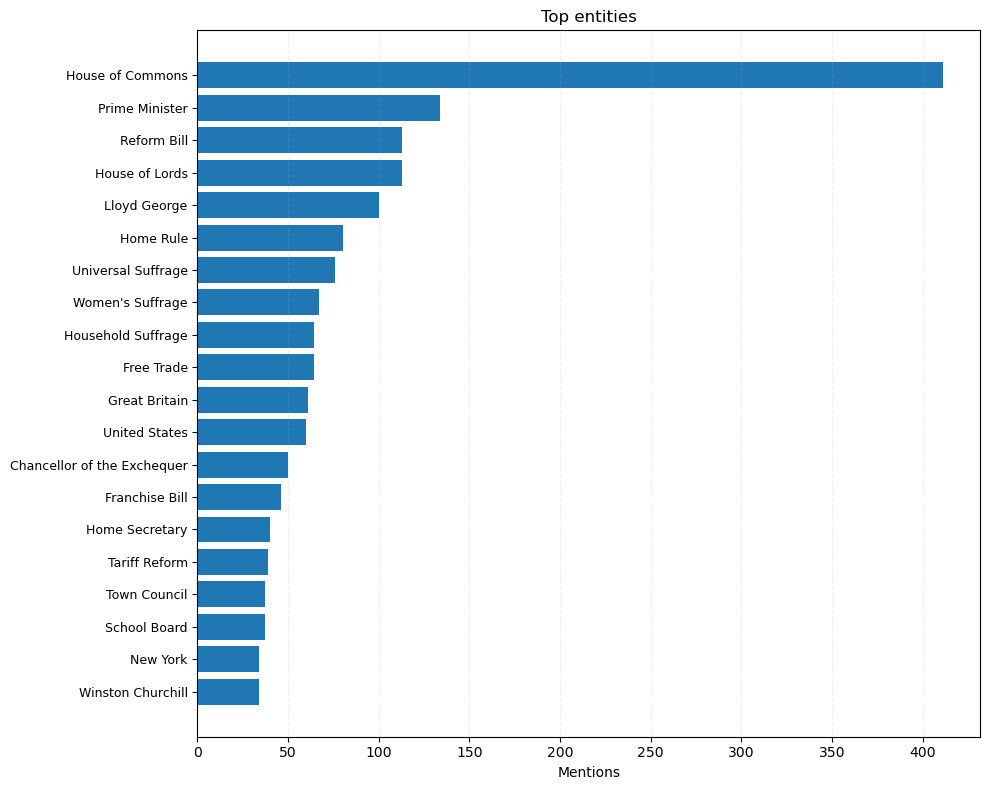

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_entities_bar(top_list, title, top_n=20, min_count=5, exclude=None):
    """
    top_list: 形如 [(entity, count), ...] 的列表（比如 Counter.most_common 的结果）
    exclude: 需要排除的实体名集合，例如 {"Editor", "Bill", ...}
    min_count: 至少出现多少次才展示
    """
    if exclude is None:
        exclude = set()

    # 过滤掉不想要的 & 低频
    filtered = [
        (ent, cnt)
        for ent, cnt in top_list
        if cnt >= min_count and ent not in exclude
    ]

    # 取前 top_n 个
    filtered = filtered[:top_n]

    if not filtered:
        print("没有符合条件的实体可以展示。")
        return

    ents, counts = zip(*filtered)

    # 为了让 barh 从下到上递增，按频次排序
    order = np.argsort(counts)  # 从小到大
    ents = [ents[i] for i in order]
    counts = [counts[i] for i in order]

    # 根据数量自动调节高度
    height = max(4, 0.4 * len(ents))

    plt.figure(figsize=(10, height))
    plt.barh(range(len(ents)), counts)
    plt.yticks(range(len(ents)), ents, fontsize=9)
    plt.xlabel("Mentions")
    plt.title(title)
    plt.grid(axis="x", alpha=0.2, linestyle="--")
    plt.tight_layout()
    plt.show()

exclude = {"Editor", "Bill", "Let", "M P", "TO THE EDITOR OF THE TIMES", "OUR LONDON LETTER", "Parliamentary", "TO THE EDITOR OF THE COURIER", "Editor of the Manchester Courier", "LONDON LETTER"}
plot_top_entities_bar(top_entities, "Top entities", top_n=20, min_count=10, exclude=exclude)


In [84]:
import numpy as np
import matplotlib.pyplot as plt

def entity_trend_over_time(
    ner_df,
    target_entities=None,
    normalize=True,
    min_total_count=5,
    title="Entity salience over time (5-year bins)"
):
    """
    绘制若干实体在各 5 年时间段中的变化趋势。

    参数说明：
    - ner_df: DataFrame，至少包含 ['entity', 'year_5bin']
    - target_entities: 
        list[str]，想看的实体名；
        如果为 None，则自动选出全局 top 实体（适合先看看大概形状）
    - normalize:
        True  -> 每个时间段内做相对频率（除以该段所有实体总数），
                 用来比较不同时间段的“关注度”；
        False -> 用原始提及次数。
    - min_total_count:
        该实体在全时期出现次数少于这个数则不画，避免噪声折线。
    - title: 图标题
    """

    df = ner_df.copy()

    # 如果没传 target_entities，就按全局频次选几个 top 实体来画
    if target_entities is None:
        from collections import Counter
        cnt = Counter(df["entity"])
        # 过滤极低频和明显垃圾的可以在这里加条件
        target_entities = [
            e for e, c in cnt.most_common(15)
            if c >= min_total_count
        ]

    # 过滤只保留关心的实体
    df = df[df["entity"].isin(target_entities)]

    # 全时期总频次，后面用来滤掉太稀的
    from collections import Counter
    total_cnt = Counter(df["entity"])

    valid_entities = [e for e in target_entities if total_cnt[e] >= min_total_count]
    if not valid_entities:
        print("没有满足 min_total_count 的实体可画。")
        return

    df = df[df["entity"].isin(valid_entities)]

    if df.empty:
        print("筛选后 ner_df 为空，检查实体名是否匹配。")
        return

    # 计算每个时间段的所有实体总数（归一化用）
    if normalize:
        total_per_bin = (
            ner_df.groupby("year_5bin")["entity"]
            .count()
            .rename("total_in_bin")
        )

    # 构造 year_5bin × entity 的矩阵
    pivot = (
        df.groupby(["year_5bin", "entity"])
          .size()
          .reset_index(name="count")
          .pivot(index="year_5bin", columns="entity", values="count")
          .fillna(0)
          .sort_index()
    )

    if normalize:
        # 对每一列：count / bin内所有实体数
        for col in pivot.columns:
            pivot[col] = pivot[col] / total_per_bin

    # ===== 画图 =====
    x = pivot.index.values
    plt.figure(figsize=(10, 6))

    for ent in pivot.columns:
        y = pivot[ent].values
        plt.plot(
            x,
            y,
            marker="o",
            linewidth=2,
            label=ent
        )

    plt.xlabel("5-year period (start year)")
    plt.ylabel("Relative mentions" if normalize else "Mentions")
    plt.title(title)
    plt.xticks(
        x,
        [f"{int(v)}–{int(v+4)}" for v in x],
        rotation=45
    )
    plt.grid(alpha=0.2, linestyle="--")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    return pivot


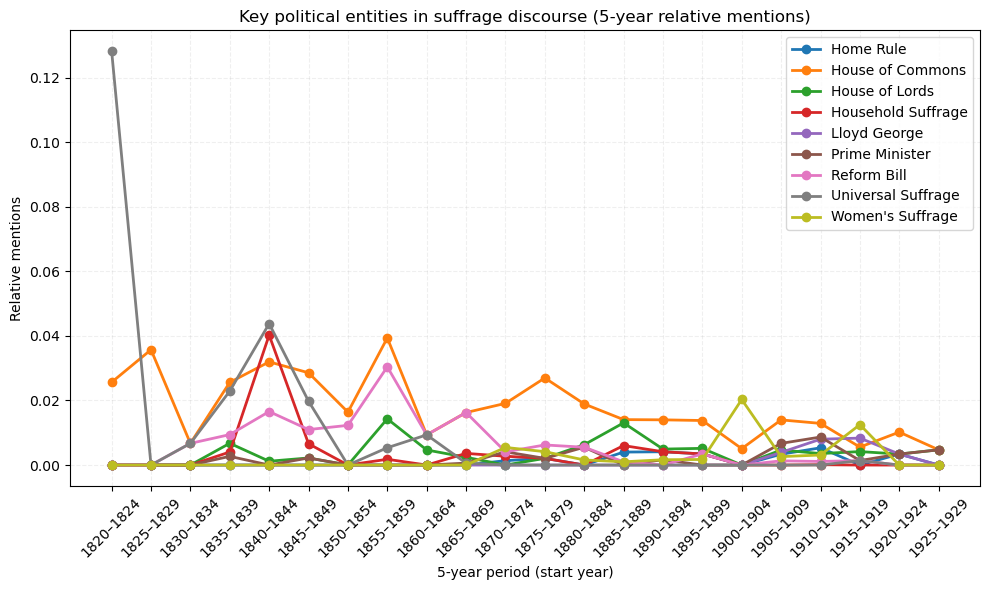

entity,Home Rule,House of Commons,House of Lords,Household Suffrage,Lloyd George,Prime Minister,Reform Bill,Universal Suffrage,Women's Suffrage
year_5bin,,,,,,,,,
1820,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.128205,0.000000
1825,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1830,0.000000,0.006711,0.000000,0.000000,0.000000,0.000000,0.006711,0.006711,0.000000
1835,0.000000,0.025606,0.006739,0.004043,0.000000,0.002695,0.009434,0.022911,0.000000
1840,0.000000,0.031953,0.001183,0.040237,0.000000,0.000000,0.016568,0.043787,0.000000
1845,0.000000,0.028571,0.002198,0.006593,0.000000,0.002198,0.010989,0.019780,0.000000
1850,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.012295,0.000000,0.000000
1855,0.000000,0.039356,0.014311,0.001789,0.000000,0.000000,0.030411,0.005367,0.000000
1860,0.000000,0.009346,0.004673,0.000000,0.000000,0.000000,0.009346,0.009346,0.000000


In [88]:

focus_entities = [
    "House of Commons",
    "House of Lords",
    "Prime Minister",
    "Universal Suffrage",
    "Lloyd George",
    "Reform Bill",
    "Women's Suffrage",
    "Household Suffrage",
    "Home Rule"
    
]

entity_trend_over_time(
    ner_df,
    target_entities=focus_entities,
    normalize=True,
    min_total_count=10,
    title="Key political entities in suffrage discourse (5-year relative mentions)"
)


In [90]:
import numpy as np
import pandas as pd

TEXT_COL = "text"

df = corpus_df.copy()
df["date_standard"] = pd.to_datetime(df["date_standard"], errors="coerce")
df = df.dropna(subset=[TEXT_COL, "date_standard"])

# 只看 1928 年前
df = df[df["date_standard"] < "1928-01-01"].copy()

df["year"] = df["date_standard"].dt.year

def to_5yr_bin(y):
    return int((y // 5) * 5)

df["year_5bin"] = df["year"].apply(to_5yr_bin)

print("文档数:", len(df))
print("五年区间:", sorted(df["year_5bin"].unique()))


文档数: 1150
五年区间: [1815, 1820, 1825, 1830, 1835, 1840, 1845, 1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925]


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=5,          # 至少在 5 篇文档中出现
    max_df=0.8,        # 出现在 80%+ 文档里的词扔掉
    ngram_range=(1,2)  # 一元词 + 二元短语，更适合话语分析
)

X = vectorizer.fit_transform(df[TEXT_COL])
terms = vectorizer.get_feature_names_out()

X.shape


(1150, 15118)

In [94]:
from sklearn.cluster import KMeans

NUM_TOPICS = 10

kmeans = KMeans(
    n_clusters=NUM_TOPICS,
    random_state=42,
    n_init=10
)
df["cluster_id"] = kmeans.fit_predict(X)


In [96]:
def print_cluster_topics(kmeans, terms, topn=15):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    topics = {}
    for i in range(kmeans.n_clusters):
        top_words = [terms[ind] for ind in order_centroids[i, :topn]]
        topics[i] = top_words
        print(f"Cluster {i} (size={ (df['cluster_id']==i).sum() }):")
        print("  " + ", ".join(top_words))
        print()
    return topics

cluster_top_words = print_cluster_topics(kmeans, terms, topn=15)


Cluster 0 (size=62):
  france, government, french, states, assembly, power, united states, paris, universal, tho, universal suffrage, country, people, republic, united

Cluster 1 (size=141):
  mr, tho, london, house, th, women, lord, lady, day, night, members, miss, ar, police, letter

Cluster 2 (size=169):
  mr, house, london, lord, government, asquith, mr asquith, george, sir, women, night, members, tho, time, commons

Cluster 3 (size=174):
  women, suffrage, woman, women suffrage, vote, men, sir, mr, franchise, editor, woman suffrage, political, national, question, sex

Cluster 4 (size=239):
  mr, suffrage, men, classes, sir, people, working, man, reform, universal, franchise, present, editor, political, class

Cluster 5 (size=43):
  reform, electors, mr, boroughs, bright, members, john bright, suffrage, household suffrage, mr bright, house, household, john, liberal, lord

Cluster 6 (size=41):
  tbe, mr, house, ia, bis, land, sir, man, tha, country, tbat, men, great, reform, lords



In [98]:
from collections import Counter

cluster_sizes = Counter(df["cluster_id"])
total_docs = len(df)
MIN_SIZE = max(10, int(0.02 * total_docs))  # 至少10篇或者 2%

topic_labels = {}

for cid in range(NUM_TOPICS):
    size = cluster_sizes[cid]
    top_words = cluster_top_words[cid][:6]
    if size < MIN_SIZE:
        topic_labels[cid] = "Others"
    else:
        # 用 top words 拼出一个粗略 label，后面你可以手动润色
        topic_labels[cid] = "Topic {}: {}".format(
            cid,
            ", ".join(top_words)
        )

df["topic_label"] = df["cluster_id"].map(topic_labels)


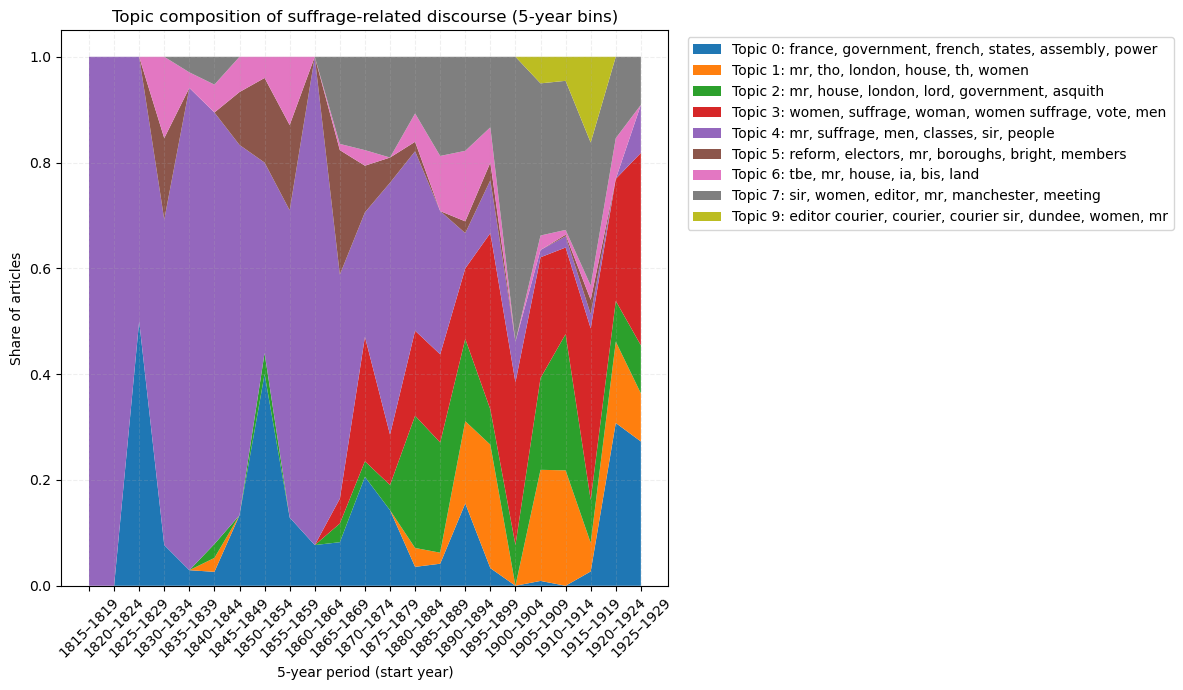

In [100]:
import matplotlib.pyplot as plt

def plot_topic_share_by_5yr(df, min_total=30):
    # 只保留出现总量达到一定门槛的 topic（避免 Others 过细）
    topic_counts = df["topic_label"].value_counts()
    valid_topics = topic_counts[topic_counts >= min_total].index.tolist()

    # year_5bin × topic 的文档数
    counts = (
        df[df["topic_label"].isin(valid_topics)]
        .groupby(["year_5bin", "topic_label"])
        .size()
        .reset_index(name="count")
    )

    # 转成矩阵
    pivot = counts.pivot(
        index="year_5bin",
        columns="topic_label",
        values="count"
    ).fillna(0).sort_index()

    # 换成占比（每个 5 年段内各 topic 所占比例）
    pivot_share = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

    x = pivot_share.index.values

    plt.figure(figsize=(12, 7))
    ys = [pivot_share[col].values for col in pivot_share.columns]

    plt.stackplot(x, *ys, labels=pivot_share.columns)
    plt.xlabel("5-year period (start year)")
    plt.ylabel("Share of articles")
    plt.title("Topic composition of suffrage-related discourse (5-year bins)")
    plt.xticks(
        x,
        [f"{int(v)}–{int(v+4)}" for v in x],
        rotation=45
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.grid(alpha=0.2, linestyle="--")
    plt.tight_layout()
    plt.show()

plot_topic_share_by_5yr(df)


In [ ]:
def plot_selected_topics(df, selected_labels, normalize=True):
    data = df[df["topic_label"].isin(selected_labels)].copy()

    counts = (
        data.groupby(["year_5bin", "topic_label"])
            .size()
            .reset_index(name="count")
    )

    pivot = counts.pivot(
        index="year_5bin",
        columns="topic_label",
        values="count"
    ).fillna(0).sort_index()

    if normalize:
        pivot = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

    x = pivot.index.values
    plt.figure(figsize=(10, 6))
    for col in pivot.columns:
        plt.plot(
            x,
            pivot[col].values,
            marker="o",
            linewidth=2,
            label=col
        )
    plt.xlabel("5-year period")
    plt.ylabel("Share of articles" if normalize else "Count")
    plt.title("Selected topic trends over time")
    plt.xticks(
        x,
        [f"{int(v)}–{int(v+4)}" for v in x],
        rotation=45
    )
    plt.grid(alpha=0.2, linestyle="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 举例：你看完 print_cluster_topics 后选几个 label
# selected = [
#     "Topic 0: ...",   # 比如议会程序
#     "Topic 3: ...",   # 比如激进行动/暴力
#     "Topic 5: ...",   # 比如权利/民主/平等
# ]
# plot_selected_topics(df, selected, normalize=True)
